In [0]:
%matplotlib inline 
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import pickle
from sklearn.utils import class_weight

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
import warnings
warnings.filterwarnings('ignore')

In [0]:
import tensorflow as tf
print('Tensorflow version:', tf.__version__)

Tensorflow version: 2.2.0


#### Create Train/Test Subset

In [3]:
%cd /content/drive/My Drive/AD_MRI
import pickle
import pandas as pd
with open('AD_MRI_Master','rb') as f:
    master_list = pickle.load(f)
    
master_sheet = pd.DataFrame.from_dict(master_list, orient='index')
display(master_sheet.head())

from sklearn.model_selection import train_test_split

train_list,test_list,train_label,test_label = train_test_split(master_sheet.subject.values,
                                                               master_sheet.diagnosis.values
                                                               ,random_state = 1337,test_size=0.2)


AD_count = 0
for lab in train_label:
    if lab == 'AD':
        AD_count +=1

print('train_ratio AD: ',AD_count/len(train_label))

AD_count = 0
for lab in test_label:
    if lab == 'AD':
        AD_count +=1
print('test_ratio AD: ',AD_count/len(test_label))
#ratios are the same, we're good to go. 



/content/drive/My Drive/AD_MRI


,subject,age,diagnosis,scan_ID
OAS30001,OAS30001,65.0,CN,OAS30001_MR_d0129
OAS30002,OAS30002,68.0,CN,OAS30002_MR_d0371
OAS30003,OAS30003,60.0,CN,OAS30003_MR_d0558
OAS30004,OAS30004,58.0,CN,OAS30004_MR_d1101
OAS30005,OAS30005,48.0,CN,OAS30005_MR_d0143


train_ratio AD:  0.36862244897959184
test_ratio AD:  0.3622448979591837


### Create Generator

In [0]:
processed_dir = '/content/drive/My Drive/AD_MRI/PROCESSED/'

# custom data generator.
import random
import scipy
import numpy as np
import cv2
from tensorflow.keras.utils import Sequence
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder
import random

import scipy

def labels_to_categorical(labels):
    le = LabelEncoder()
    le.fit(["CN", "AD"])
    num_lab=to_categorical(le.transform(labels),num_classes=2)
    return num_lab



class MyDataGenerator(Sequence):
    """Generates data for Keras
    Sequence based data generator. Suitable for building data generator for training and prediction.
    """
    def __init__(self, list_IDs, processed_dir,augment=False, 
                 to_fit=True, batch_size=32, dim=(120, 160, 120, 1),
                 n_classes=2, shuffle=True, ventricals_only = True):
        """Initialization
        :param list_IDs: list of all 'label' PATHS
        :param labels: list of image labels ***MUST ALREADY BE (N X 2) ARRAY***
        :param image_path: path to images location
        # 
        :param to_fit: True to return X and y, False to return X only
        :param batch_size: batch size at each iteration
        :param dim: tuple indicating image dimension
        :param n_channels: number of image channels
        :param n_classes: number of output masks
        :param shuffle: True to shuffle label indexes after every epoch
        """
        self.list_IDs = list_IDs
        self.processed_dir = processed_dir
        #self.labels = labels
        self.augment = augment
        self.ventricals_only = ventricals_only
        #self.image_path = image_path not needed
        #self.mask_path = mask_path   not needed
        self.to_fit = to_fit
        self.batch_size = batch_size
        self.dim = dim
        #self.n_channels = n_channels
        self.n_classes = n_classes
        self.shuffle = shuffle
        self.on_epoch_end()

    def __len__(self):
        """Denotes the number of batches per epoch
        :return: number of batches per epoch
        """
        return int(np.floor(len(self.list_IDs) / self.batch_size))

    def __getitem__(self, index):
        """Generate one batch of data
        :param index: index of the batch
        :return: X and y when fitting. X only when predicting
        """
        # Generate indexes of the batch
        indexes = self.indexes[index * self.batch_size:(index + 1) * self.batch_size]

        # Find list of IDs
        list_IDs_temp = [self.list_IDs[k] for k in indexes]
        
        # Generate data
        X,y = self._load_data(list_IDs_temp)
        X=np.float32(X)
        if self.ventricals_only:
          X = X[:,:,:,50:66,:]
        if self.to_fit:
            y= {'classifier':y,'ICAE_decoder':X}
            return X,y
        else:
            return X

    def on_epoch_end(self):
        """Updates indexes after each epoch
        """
        self.indexes = np.arange(len(self.list_IDs))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)

    def _load_data(self, list_IDs_temp):
        """Generates data containing batch_size images
        :param list_IDs_temp: list of label ids to load
        :return: batch of images
        """
        # Initialization
        X = np.empty((self.batch_size, *self.dim))
        y = np.empty((self.batch_size,self.n_classes), dtype=int)
        
        
        # Generate data
        for i, ID in enumerate(list_IDs_temp):
            
            #start X
            with open(self.processed_dir+ID+'_data','rb') as f:
                data = pickle.load(f)
                
            
            x_reshape= np.reshape(data['image'], (120, 160, 120, 1) )
            if self.augment == True:
                x_reshape = scipy.ndimage.rotate(x_reshape, 
                                           axes=random.choice([(0,1),(0,2),(1,2)]),
                                           angle=random.choice([360-15,15]),
                                           reshape=False)
            X[i,] = x_reshape
            
            #start y
            y[i,] = labels_to_categorical([data['diagnosis']])
            
            

        return X,y

    

In [0]:
processed_dir = '/content/drive/My Drive/AD_MRI/PROCESSED/'
mdg= MyDataGenerator(test_list,processed_dir,to_fit=True,augment=True,batch_size=2)

X,pred=mdg.__getitem__(0)




In [0]:
X.shape

(2, 120, 160, 15, 1)

##### --- Start adaptation from Arezoo's notebook ---

TypeError: ignored

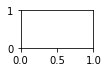

In [0]:
import matplotlib.pyplot as plt
axs,fig = plt.subplot(5,4,1)
for i in range(20):

  plt.imshow(X[0,:,:,55+i,0])





#### Building Encoder

In [0]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import backend as K
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Conv3D, MaxPool3D, Dropout, \
    Flatten, Conv3DTranspose, UpSampling3D, Reshape
from tensorflow.keras.layers import Input


In [0]:
input_img = Input(shape=(120, 160, 120 , 1), name='Input')

print('\ninput shape:', input_img.shape)

x = Conv3D(10, (3,3,3), activation='relu', padding='same', name='Convolution_1')(input_img)
x = MaxPool3D((2,2,2), name='MaxPooling_1')(x)
x = Dropout(0.8, name='DropOut_1')(x)

x = Conv3D(10, (3,3,3), activation='relu', padding='same', name='Convolution_2')(x)
x = MaxPool3D((2,2,2), name='MaxPooling_2')(x)
x = Dropout(0.8, name='DropOut_2')(x)

x = Conv3D(10, (3,3,3), activation='relu', padding='same', name='Convolution_3')(x)
x = MaxPool3D((2,2,2), name='MaxPooling_3')(x)
x = Dropout(0.8, name='DropOut_3')(x)

conv_shape = K.int_shape(x)

print('shape after convolutions:', conv_shape)

# x = Flatten(name='Flatten')(x)

# x = Dense(32, activation='selu', name='SELU_1')(x)
# x = Dense(16, activation='selu', name='SELU_2')(x)

# encoded = Dense(2, name='Encoded')(x)

# encoded_shape = K.int_shape(encoded)

# print('final encoded shape:', encoded_shape, '\n')

encoded = x
encoded_shape = K.int_shape(encoded)


encoder = Model(input_img, encoded, name='CAE_encoder')
encoder.summary()



input shape: (None, 120, 160, 120, 1)
shape after convolutions: (None, 15, 20, 15, 10)
Model: "CAE_encoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Input (InputLayer)           [(None, 120, 160, 120, 1) 0         
_________________________________________________________________
Convolution_1 (Conv3D)       (None, 120, 160, 120, 10) 280       
_________________________________________________________________
MaxPooling_1 (MaxPooling3D)  (None, 60, 80, 60, 10)    0         
_________________________________________________________________
DropOut_1 (Dropout)          (None, 60, 80, 60, 10)    0         
_________________________________________________________________
Convolution_2 (Conv3D)       (None, 60, 80, 60, 10)    2710      
_________________________________________________________________
MaxPooling_2 (MaxPooling3D)  (None, 30, 40, 30, 10)    0         
_________________________________

In [0]:
# model only: post-encoder

# x = Flatten(name='Flatten')(x)

# x = Dense(32, activation='selu', name='SELU_1')(x)
# x = Dense(16, activation='selu', name='SELU_2')(x)

# encoded = Dense(2, name='Encoded')(x)

# encoded_shape = K.int_shape(encoded)

# print('final encoded shape:', encoded_shape, '\n')

# encoder = Model(input_img, encoded, name='CAE_encoder')
# encoder.summary()


##### CAE Encoder layers

Input

    120 x 160 x 120 x 1

Convolutional layer (10 channels, 3x3x3 kernel, ReLU activation, padding)

    120 x 160 x 120 x 10

Maxpooling downsample (2x2x2 kernel)

    60 x 80 x 60 x 10

Dropout (80% of nodes set to 0)

    60 x 80 x 60 x 10

Convolutional layer (10 channels, 3x3x3 kernel, ReLU activation, padding)

    60 x 80 x 60 x 10

Maxpooling downsample (2x2x2 kernel)

    30 x 40 x 30 x 10

Dropout (80% of nodes set to 0)

    30 x 40 x 30 x 10

Convolutional layer (10 channels, 3x3x3 kernel, ReLU activation, padding)

    30 x 40 x 30 x 10

Maxpooling downsample (2x2x2 kernel)

    15 x 20 x 15 x 10

Dropout (80% of nodes set to 0)

    15 x 20 x 15 x 10
    

<!-- ###### In the Classifier only:

Flatten

    45000

Dense layer (32 channels, SELU activation)

    32

Dense layer (16 channels, SELU activation)

    16

Dense layer (2 possible outputs)

    2
 -->

#### Building Decoder

In [0]:
encoded_shape

(None, 15, 20, 15, 10)

In [0]:
encoded_input = Input(shape=(encoded_shape[1],encoded_shape[2], encoded_shape[3], encoded_shape[4],), name='Encoded')

x = encoded_input

print('\ninput shape:', encoded_input.shape)

# x = Dense(16, activation='selu', name='SELU_2')(encoded_input)
# x = Dense(32, activation='selu', name='SELU_1')(x)
# x = Dense(np.prod(conv_shape[1:]), name='Product')(x)
# x = Reshape((conv_shape[1], conv_shape[2], conv_shape[3], conv_shape[4]), name='Reshape')(x)

# print('shape after reshape:', K.int_shape(x))

x = Conv3DTranspose(10, (3,3,3), activation='relu', padding='same', name='Convolution_3')(x)
x = UpSampling3D((2,2,2), name='UpSampling_3')(x)
x = Dropout(0.8, name='DropOut_3')(x)

x = Conv3DTranspose(10, (3,3,3), activation='relu', padding='same', name='Convolution_2')(x)
x = UpSampling3D((2,2,2), name='UpSampling_2')(x)
x = Dropout(0.8, name='DropOut_2')(x)

x = Conv3DTranspose(10, (3,3,3), activation='relu', padding='same', name='Convolution_1')(x)
x = UpSampling3D((2,2,2), name='UpSampling_1')(x)
x = Dropout(0.8, name='DropOut_1')(x)

# decoded = Dense(1, activation='sigmoid', name='Output')(x)
decoded = Conv3DTranspose(1, (3,3,3), activation='sigmoid', padding='same', name='Output')(x)

print('final decoded shape:', K.int_shape(decoded), '\n')

decoder = Model(encoded_input, decoded, name='CAE_decoder')
decoder.summary()



input shape: (None, 15, 20, 15, 10)
final decoded shape: (None, 120, 160, 120, 1) 

Model: "CAE_decoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Encoded (InputLayer)         [(None, 15, 20, 15, 10)]  0         
_________________________________________________________________
Convolution_3 (Conv3DTranspo (None, 15, 20, 15, 10)    2710      
_________________________________________________________________
UpSampling_3 (UpSampling3D)  (None, 30, 40, 30, 10)    0         
_________________________________________________________________
DropOut_3 (Dropout)          (None, 30, 40, 30, 10)    0         
_________________________________________________________________
Convolution_2 (Conv3DTranspo (None, 30, 40, 30, 10)    2710      
_________________________________________________________________
UpSampling_2 (UpSampling3D)  (None, 60, 80, 60, 10)    0         
____________________________________

<!-- 
 ###### In the Classifier only:


Input

    2

Dense layer (16 channels, SELU activation)

    16

Dense layer (32 channels, SELU activation)

    32

Dense layer (product of encoded_shape dimensions 15x20x15x10)

    45000

Reshape to encoded_shape dimensions

    15 x 20 x 15 x 10 
    
     -->
##### CAE Decoder layers

Input

    15 x 20 x 15 x 10

Convolutional transpose layer (10 channels, 3x3x3 kernel, ReLU activation, padding)

    15 x 20 x 15 x 10

Upsampling (2x2x2 kernel)

    30 x 40 x 30 x 10

Dropout (80% of nodes set to 0)

    30x 40 x 30 x 10

Convolutional transpose layer (10 channels, 3x3x3 kernel, ReLU activation, padding)

    30 x 40 x 30 x 10

Upsampling (2x2x2 kernel)

    60 x 80 x 60 x 10

Dropout (80% of nodes set to 0)

    60 x 80 x 60 x 10

Convolutional transpose layer (10 channels, 3x3x3 kernel, ReLU activation, padding)

    60 x 80 x 60 x 10

Upsampling (2x2x2 kernel)

    120 x 160 x 120 x 10

Dropout (80% of nodes set to 0)

    120 x 160 x 120 x 10

Convolutional transpose layer (1 channel, 3x3x3 kernel, sigmoid activation, padding)

    120 x 160 x 120 x 1


#### Building Autoencoder

In [0]:
autoencoder = Model(input_img, decoder(encoder(input_img)), name='CAE_autoencoder')
autoencoder.summary()

Model: "CAE_autoencoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Input (InputLayer)           [(None, 120, 160, 120, 1) 0         
_________________________________________________________________
CAE_encoder (Model)          (None, 15, 20, 15, 10)    5700      
_________________________________________________________________
CAE_decoder (Model)          (None, 120, 160, 120, 1)  8401      
Total params: 14,101
Trainable params: 14,101
Non-trainable params: 0
_________________________________________________________________


In [0]:
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')

#hist = autoencoder.fit(x_train, x_train, epochs=1, verbose=1, validation_data=(x_test, x_test)) # epochs=200

##### --- End adaption from Arezoo's notebook ---

### ICAE Inception Model

#### Building Encoder

In [0]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import backend as K
from tensorflow.keras.callbacks import TensorBoard
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Conv3D, MaxPool3D, Dropout, Flatten, \
    Conv3DTranspose, UpSampling3D, Reshape
from tensorflow.keras.layers import Input

from tensorflow.keras.layers import concatenate
from tensorflow.keras.regularizers import l1_l2


In [0]:
def inception_module(input, filter_operation):
    """
    filter_operation is a list of inception operations for:
        1x1x1 kernel, 
        1x1x1 then 3x3x3 kernels, 
        1x1x1 then 3x3x3 then 3x3x3 kernels, 
        and 3x3x3 maxpooling then 1x1x1 kernels, 
            respectively.
    """
    
    # According to Nature paper (Oh et. al.), l1 and l2 values of 10e-4 performed the best 
    #   from experimentation with 0.01, 0.001, 0.0001, 0.00001 values.
    l1_value = 10e-4
    l2_value = 10e-4

    # Branch A
    branch_1x1x1 = Conv3D(filter_operation[0], kernel_size=(1, 1, 1), activation='relu', \
                          padding='same', kernel_regularizer=l1_l2(l1_value, l2_value), \
                          name='Branch_A_1x1x1')(input)

    # Branch B
    branch_3x3x3_initial = Conv3D(filter_operation[1], kernel_size=(1, 1, 1), activation='relu', \
                                  padding='same', kernel_regularizer=l1_l2(l1_value, l2_value), \
                                  name='Branch_B_1x1x1')(input)
    branch_3x3x3 = Conv3D(filter_operation[1], kernel_size=(3, 3, 3), activation='relu', \
                          padding='same', kernel_regularizer=l1_l2(l1_value, l2_value), \
                          name='Branch_B_3x3x3')(branch_3x3x3_initial)

    # Branch C
    branch_double_3x3x3_initial = Conv3D(filter_operation[2], kernel_size=(1, 1, 1), \
                                         activation='relu', padding='same', \
                                         kernel_regularizer=l1_l2(l1_value, l2_value), \
                                         name='Branch_C_1x1x1')(input)
    branch_double_3x3x3_middle = Conv3D(filter_operation[2], kernel_size=(3, 3, 3), \
                                        activation='relu', padding='same', \
                                        kernel_regularizer=l1_l2(l1_value, l2_value), \
                                        name='Branch_C_1st_3x3x3')(branch_double_3x3x3_initial)
    branch_double_3x3x3 = Conv3D(filter_operation[2], kernel_size=(3, 3, 3), activation='relu', \
                                 padding='same', kernel_regularizer=l1_l2(l1_value, l2_value), \
                                 name='Branch_C_2nd_3x3x3')(branch_double_3x3x3_middle)

    # Branch D
    branch_maxpool_3x3x3_initial = MaxPool3D(pool_size=(3, 3, 3), strides=(1, 1, 1), \
                                             padding='same', name='Branch_D_3x3x3_maxpool')(input)
    branch_maxpool_3x3x3 = Conv3D(filter_operation[3], kernel_size=(1, 1, 1), activation='relu', \
                                  padding='same', kernel_regularizer=l1_l2(l1_value, l2_value), \
                                  name='Branch_D_1x1x1')(branch_maxpool_3x3x3_initial)
    
    # Merge branches
    modules = [branch_1x1x1, branch_3x3x3, branch_double_3x3x3, branch_maxpool_3x3x3]
    merged_module = concatenate(modules, name='Inception_Merged') # axis=-1
    
    return merged_module
    

In [27]:
input_img = Input(shape= (120, 160, 16 , 1), name='Input')

print('\ninput shape:', input_img.shape)

x = Conv3D(10, (3,3,3), activation='relu', padding='same', name='Convolution_1')(input_img)
x = MaxPool3D((2,2,2), name='MaxPooling_1')(x)
x = Dropout(0.8, name='DropOut_1')(x)

x = Conv3D(10, (3,3,3), activation='relu', padding='same', name='Convolution_2')(x)
x = MaxPool3D((2,2,2), name='MaxPooling_2')(x)
x = Dropout(0.8, name='DropOut_2')(x)

# filter_operations = [40, 40, 40, 40]
filter_operations = [10, 10, 10, 10]

x = inception_module(x, filter_operations)
x = MaxPool3D((2,2,2), name='Inception_MaxPooling')(x)
encoded = Dropout(0.8, name='DropOut_3')(x)

# print('shape after inception:', K.int_shape(x))

# ## for model only
# encoded = Flatten(name='Flatten')(encoded)
# encoded = Dense(1, activation='sigmoid', name='Prediction')(encoded)
# ##

encoder = Model(input_img, encoded, name='ICAE_encoder')

encoded_shape = K.int_shape(encoded)
print('final encoded shape:', encoded_shape, '\n')

encoder.summary(positions=[.35, .64, .71, 1.]) # adjusts print settings to minimize truncation



input shape: (None, 120, 160, 16, 1)
final encoded shape: (None, 15, 20, 2, 40) 

Model: "ICAE_encoder"
__________________________________________________________________________________________________
Layer (type)                      Output Shape                Param  Connected to                 
Input (InputLayer)                [(None, 120, 160, 16, 1)]   0                                   
__________________________________________________________________________________________________
Convolution_1 (Conv3D)            (None, 120, 160, 16, 10)    280    Input[0][0]                  
__________________________________________________________________________________________________
MaxPooling_1 (MaxPooling3D)       (None, 60, 80, 8, 10)       0      Convolution_1[0][0]          
__________________________________________________________________________________________________
DropOut_1 (Dropout)               (None, 60, 80, 8, 10)       0      MaxPooling_1[0][0]           
____

##### ICAE Encoder layers

Input

    120 x 160 x 120 x 1

Convolutional layer (10 channels, 3x3x3 kernel, ReLU activation, padding)

    120 x 160 x 120 x 10

Maxpooling downsample (2x2x2 kernel)

    60 x 80 x 60 x 10

Convolutional layer (10 channels, 3x3x3 kernel, ReLU activation, padding)

    60 x 80 x 60 x 10

Maxpooling downsample (2x2x2 kernel)

    30 x 40 x 30 x 10

Dropout (80% of nodes set to 0)

    30 x 40 x 30 x 10

Inception branched layers

    A: 30 x 40 x 30 x 10

    B: 30 x 40 x 30 x 10  ->  30 x 40 x 30 x 10

    C: 30 x 40 x 30 x 10  ->  30 x 40 x 30 x 10  ->  30 x 40 x 30 x 10

    D: 30 x 40 x 30 x 10  ->  30 x 40 x 30 x 10

Inception merged layer

    30 x 40 x 30 x 40

Maxpooling downsample (2x2x2 kernel)

    15 x 20 x 15 x 40

Dense layer (2 possible outputs, SoftMax activation)

    15 x 20 x 15 x 2


#### Building Decoder

In [28]:
encoded_input= Input(shape=(encoded_shape[1],encoded_shape[2], \
                            encoded_shape[3], encoded_shape[4],), name='Input')

print('\ninput shape:', encoded_input.shape)

filter_operations = [40, 40, 40, 40]
filter_operations = [10, 10, 10, 10]
combined_dim = sum(filter_operations) # taken from encoder

x = Dense(combined_dim, activation='selu', name='SELU')(encoded_input)

### ************
x = encoded_input
x = inception_module(x, filter_operations)
### ************
# print('shape after inception:', K.int_shape(x))

x = UpSampling3D((2,2,2), name='Inception_Upsampling')(x)
x = Dropout(0.8, name='DropOut_3')(x)

x = Conv3DTranspose(10, (3,3,3), activation='relu', padding='same', name='Convolution_2')(x)
x = UpSampling3D((2,2,2), name='Upsampling_2')(x)
x = Dropout(0.8, name='DropOut_2')(x)

x = Conv3DTranspose(10, (3,3,3), activation='relu', padding='same', name='Convolution_1')(x)
x = UpSampling3D((2,2,2), name='Upsampling_1')(x)
x = Dropout(0.8, name='DropOut_1')(x)

# decoded = Dense(1, activation='sigmoid', name='Output')(x)
decoded = Conv3DTranspose(1, (3,3,3), activation='sigmoid', padding='same', name='Output')(x)

print('final decoded shape:', K.int_shape(decoded), '\n')

decoder = Model(encoded_input, decoded, name='ICAE_decoder')
decoder.summary(positions=[.35, .64, .71, 1.])



input shape: (None, 15, 20, 2, 40)
final decoded shape: (None, 120, 160, 16, 1) 

Model: "ICAE_decoder"
__________________________________________________________________________________________________
Layer (type)                      Output Shape                Param  Connected to                 
Input (InputLayer)                [(None, 15, 20, 2, 40)]     0                                   
__________________________________________________________________________________________________
Branch_C_1x1x1 (Conv3D)           (None, 15, 20, 2, 10)       410    Input[0][0]                  
__________________________________________________________________________________________________
Branch_B_1x1x1 (Conv3D)           (None, 15, 20, 2, 10)       410    Input[0][0]                  
__________________________________________________________________________________________________
Branch_C_1st_3x3x3 (Conv3D)       (None, 15, 20, 2, 10)       2710   Branch_C_1x1x1[0][0]         
____

##### ICAE Decoder layers

Input

    15 x 20 x 15 x 10

Inception branched layers

    A: 15 x 20 x 15 x 10

    B: 15 x 20 x 15 x 10  ->  15 x 20 x 15 x 10

    C: 15 x 20 x 15 x 10  ->  15 x 20 x 15 x 10  ->  15 x 20 x 15 x 10

    D: 15 x 20 x 15 x 10  ->  15 x 20 x 15 x 10

Upsampling (2x2x2 kernel)

    30 x 40 x 30 x 10

Dropout (80% of nodes set to 0)

    30x 40 x 30 x 10

Convolutional transpose layer (10 channels, 3x3x3 kernel, ReLU activation, padding)

    30 x 40 x 30 x 10

Upsampling (2x2x2 kernel)

    60 x 80 x 60 x 10

Dropout (80% of nodes set to 0)

    60 x 80 x 60 x 10

Convolutional transpose layer (10 channels, 3x3x3 kernel, ReLU activation, padding)

    60 x 80 x 60 x 10

Upsampling (2x2x2 kernel)

    120 x 160 x 120 x 10

Dropout (80% of nodes set to 0)

    120 x 160 x 120 x 10

Convolutional transpose layer (1 channel, 3x3x3 kernel, sigmoid activation, padding)

    120 x 160 x 120 x 1



#### Building Autoencoder

In [29]:
#classifier

encoded_input = Input(shape=(encoded_shape[1],encoded_shape[2], encoded_shape[3], encoded_shape[4],), name='Encoded')
y = encoded_input
y = Flatten()(y)
y = Dropout(0.5)(y)
y = Dense(32,activation='selu')(y)
y = Dropout(0.5)(y)
y = Dense(16,activation='selu')(y)
class_pred = Dense(2,activation='softmax')(y)

classifier = Model(encoded_input,class_pred,name='classifier')

classifier.summary()

Model: "classifier"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Encoded (InputLayer)         [(None, 15, 20, 2, 40)]   0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 24000)             0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 24000)             0         
_________________________________________________________________
dense_3 (Dense)              (None, 32)                768032    
_________________________________________________________________
dropout_3 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 16)                528       
_________________________________________________________________
dense_5 (Dense)              (None, 2)                 3

In [30]:
ICAE_autoencoder = Model(inputs=input_img,
                  outputs=[decoder(encoder(input_img)),classifier(encoder(input_img))],
                   name='ICAE_autoencoder')
ICAE_autoencoder.summary()

Model: "ICAE_autoencoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Input (InputLayer)              [(None, 120, 160, 16 0                                            
__________________________________________________________________________________________________
ICAE_encoder (Model)            (None, 15, 20, 2, 40 11560       Input[0][0]                      
                                                                 Input[0][0]                      
__________________________________________________________________________________________________
ICAE_decoder (Model)            (None, 120, 160, 16, 23561       ICAE_encoder[1][0]               
__________________________________________________________________________________________________
classifier (Model)              (None, 2)            768594      ICAE_encoder[2][0]

In [0]:
losses = {"ICAE_decoder":'mse','classifier':'categorical_crossentropy'}
metrics= {"ICAE_decoder":'mae','classifier':'acc'}
loss_weights={"ICAE_decoder":0.5,'classifier':0.5}

ICAE_autoencoder.compile(optimizer='sgd', 
                         loss=losses,
                         loss_weights = loss_weights,
                         metrics=metrics)

#ICAE_hist = ICAE_autoencoder.fit(x_train, x_train, epochs=1, verbose=1, \
#                                 validation_data=(x_test, x_test)) # epochs=200





In [0]:
train_generator = MyDataGenerator(train_list,processed_dir,to_fit=True,augment=False,batch_size=16)
test_generator = MyDataGenerator(test_list,processed_dir,batch_size=16)

In [47]:
history=ICAE_autoencoder.fit_generator(generator=train_generator,epochs=10,
                                       validation_data=test_generator)

Epoch 1/10
 6/49 [==>...........................] - ETA: 6:58 - loss: 1.8250 - ICAE_decoder_loss: 0.1403 - classifier_loss: 0.6735 - ICAE_decoder_mae: 0.3266 - classifier_acc: 0.5833

KeyboardInterrupt: ignored

In [0]:
history=ICAE_autoencoder.fit(train_generator,epochs=10, use_multiprocessing=True,
                                       validation_data=test_generator)

Epoch 1/10
49/49 [==============================] - 724s 15s/step - loss: 1.8054 - ICAE_decoder_loss: 0.1164 - classifier_loss: 0.6717 - ICAE_decoder_mae: 0.2952 - classifier_acc: 0.6250 - val_loss: 1.7885 - val_ICAE_decoder_loss: 0.1090 - val_classifier_loss: 0.6572 - val_ICAE_decoder_mae: 0.2853 - val_classifier_acc: 0.6406
Epoch 2/10
26/49 [==============>...............] - ETA: 2:46 - loss: 1.7949 - ICAE_decoder_loss: 0.1113 - classifier_loss: 0.6738 - ICAE_decoder_mae: 0.2874 - classifier_acc: 0.6226

In [34]:
X.shape

(4, 120, 160, 16, 1)

In [0]:
out= ICAE_autoencoder.predict(X)

In [36]:
out[0].shape

(4, 120, 160, 16, 1)

(4, 120, 160, 15, 1)